In [1]:
import numpy as np
import cv2
from scipy import sparse
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt
import os

In [2]:
class ImageBlender:
    
    def __init__(self):
        """Initialize the ImageBlender."""
        pass
    
    @staticmethod
    def create_mask(img, interactive=False):

        if interactive:
            # Create a window for drawing
            mask = np.zeros(img.shape[:2], dtype=np.uint8)
            clone = img.copy()
            cv2.namedWindow("Draw Mask")
            cv2.setMouseCallback("Draw Mask", lambda event, x, y, flags, param: ImageBlender._draw_mask(event, x, y, flags, param, mask, img, clone))
            
            print("Draw the mask over the area you want to keep. Press 'r' to reset, 'c' to confirm.")
            while True:
                cv2.imshow("Draw Mask", clone)
                key = cv2.waitKey(1) & 0xFF
                
                if key == ord("r"):  # Reset
                    mask = np.zeros(img.shape[:2], dtype=np.uint8)
                    clone = img.copy()
                elif key == ord("c"):  # Confirm
                    break
                    
            cv2.destroyAllWindows()
            return mask
        else:
            # Try to extract foreground automatically
            # Convert to grayscale if it's a color image
            if len(img.shape) > 2:
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            else:
                gray = img.copy()
                
            # Apply thresholding to create a rough mask
            _, rough_mask = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY_INV)
            
            # Find contours in the rough mask
            contours, _ = cv2.findContours(rough_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            
            # Create a refined mask by filling the largest contour
            refined_mask = np.zeros_like(rough_mask)
            if contours:
                # Find the largest contour
                largest_contour = max(contours, key=cv2.contourArea)
                cv2.drawContours(refined_mask, [largest_contour], 0, 255, -1)
            
            # If mask is too small, try grabcut algorithm
            if np.sum(refined_mask) < 0.1 * refined_mask.size:
                # Try grabcut algorithm for better segmentation
                bgdModel = np.zeros((1, 65), np.float64)
                fgdModel = np.zeros((1, 65), np.float64)
                
                # Create a rectangle around the image center
                h, w = img.shape[:2]
                rect = (w//4, h//4, w//2, h//2)
                
                mask_grabcut = np.zeros(img.shape[:2], np.uint8) + cv2.GC_PR_BGD
                cv2.grabCut(img, mask_grabcut, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)
                
                # Create binary mask from grabcut result
                refined_mask = np.where((mask_grabcut == cv2.GC_FGD) | (mask_grabcut == cv2.GC_PR_FGD), 1, 0).astype('uint8')
            
            return refined_mask

    @staticmethod
    def _draw_mask(event, x, y, flags, param, mask, img, clone):
        """Callback function for drawing a mask interactively."""
        
        if event == cv2.EVENT_LBUTTONDOWN:
            cv2.circle(mask, (x, y), 10, 1, -1)
            cv2.circle(clone, (x, y), 10, (0, 255, 0), -1)
        elif event == cv2.EVENT_MOUSEMOVE and flags & cv2.EVENT_FLAG_LBUTTON:
            cv2.circle(mask, (x, y), 10, 1, -1)
            cv2.circle(clone, (x, y), 10, (0, 255, 0), -1)

    @staticmethod
    def get_laplacian_matrix(height, width):

        # Total number of pixels
        n_pixels = height * width
        
        # Create row and column indices for the sparse matrix
        row_indices = []
        col_indices = []
        data = []
        
        # For each pixel (i, j)
        for i in range(height):
            for j in range(width):
                # Current pixel index
                p = i * width + j
                
                # Add center pixel with value 4
                row_indices.append(p)
                col_indices.append(p)
                data.append(4)
                
                # Add neighbor pixels with value -1
                for di, dj in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                    ni, nj = i + di, j + dj
                    
                    # Check if neighbor is inside the image
                    if 0 <= ni < height and 0 <= nj < width:
                        np = ni * width + nj
                        row_indices.append(p)
                        col_indices.append(np)
                        data.append(-1)
        
        # Create the sparse matrix
        L = sparse.csr_matrix((data, (row_indices, col_indices)), 
                              shape=(n_pixels, n_pixels))
        
        return L

    def _create_image_pyramid(self, img: np.ndarray) -> list:

        pyramid = [img]
        current_img = img.copy()
        
        for _ in range(self.num_levels - 1):
            height, width = current_img.shape[:2]
            
            # Stop if image is too small
            if height <= self.min_size or width <= self.min_size:
                break
                
            # Downsample
            current_img = cv2.pyrDown(current_img)
            pyramid.append(current_img)
        
        return pyramid

    @staticmethod
    def poisson_blend(source_img, target_img, mask, offset=(0, 0)):

        # Get image dimensions
        h, w = target_img.shape[:2]
        channels = target_img.shape[2] if len(target_img.shape) > 2 else 1
        
        # Offset the mask to align with the target position
        offset_mask = np.zeros_like(target_img[:, :, 0]) if channels > 1 else np.zeros_like(target_img)
        
        # Get dimensions of the mask and source image
        mask_h, mask_w = mask.shape[:2]
        source_h, source_w = source_img.shape[:2]
        
        # Make sure mask and source dimensions match
        if mask_h != source_h or mask_w != source_w:
            print(f"Warning: Mask dimensions ({mask_h}, {mask_w}) don't match source image dimensions ({source_h}, {source_w})")
            # Resize mask to match source if necessary
            if mask_h != source_h or mask_w != source_w:
                mask = cv2.resize(mask, (source_w, source_h), interpolation=cv2.INTER_NEAREST)
                mask_h, mask_w = mask.shape[:2]
                print(f"Resized mask to ({mask_h}, {mask_w})")
        
        # Calculate the valid region where the mask fits in the target image
        y_min, x_min = offset
        y_max, x_max = min(y_min + mask_h, h), min(x_min + mask_w, w)
        
        # Adjust offsets if they're negative (source partially outside target on the left/top)
        src_y_start = abs(min(0, y_min))  # If y_min is negative, start from appropriate source position
        src_x_start = abs(min(0, x_min))  # If x_min is negative, start from appropriate source position
        
        # Adjust starting positions for target image
        target_y_start = max(0, y_min)
        target_x_start = max(0, x_min)
        
        # Calculate ending positions
        src_y_end = src_y_start + (y_max - target_y_start)
        src_x_end = src_x_start + (x_max - target_x_start)
        
        # Ensure we're not going out of bounds
        src_y_end = min(src_y_end, mask_h)
        src_x_end = min(src_x_end, mask_w)
        
        # Place the mask in the offset position
        if src_y_start < src_y_end and src_x_start < src_x_end:
            offset_mask[target_y_start:y_max, target_x_start:x_max] = mask[src_y_start:src_y_end, src_x_start:src_x_end]
        else:
            print("Error: Source region is completely outside target image")
            return target_img.copy()
        
        # Make a copy of the target image
        result = target_img.copy()
        
        # Get Laplacian matrix
        L = ImageBlender.get_laplacian_matrix(h, w)
        
        # Process each channel separately
        for c in range(channels):
            # Extract the channel from source and target
            source_channel = source_img[:, :, c] if channels > 1 else source_img
            target_channel = target_img[:, :, c] if channels > 1 else target_img
            
            # Flatten the images and mask
            mask_flat = offset_mask.flatten()
            target_flat = target_channel.flatten()
            
            # Indices of interior and boundary regions
            interior_indices = np.where(mask_flat == 1)[0]
            boundary_indices = np.where(mask_flat == 0)[0]
            
            # If no interior pixels, skip this channel
            if len(interior_indices) == 0:
                continue
            
            # Create a new system matrix - optimized approach
            data = []
            row_indices = []
            col_indices = []
            
            # Set identity rows for boundary points
            for idx in boundary_indices:
                row_indices.append(idx)
                col_indices.append(idx)
                data.append(1)
            
            # Create a sparse matrix for the boundary conditions
            boundary_matrix = sparse.csr_matrix((data, (row_indices, col_indices)), 
                                            shape=(h * w, h * w))
            
            # Create a mask matrix for interior points
            interior_mask = np.zeros(h * w)
            interior_mask[interior_indices] = 1
            interior_diag = sparse.diags(interior_mask)
            
            # Combine the matrices
            L_eq = interior_diag.dot(L) + boundary_matrix
            
            # Set up the right-hand side of the equation
            b = np.zeros(h * w)
            
            # Create padded source for Laplacian calculation
            source_laplacian = np.zeros((h, w))
            
            # Calculate the Laplacian of the source image
            # This is where the original error occurred
            for i in range(h):
                for j in range(w):
                    if offset_mask[i, j] == 1:
                        # Calculate corresponding position in source image
                        src_i = i - target_y_start + src_y_start
                        src_j = j - target_x_start + src_x_start
                        
                        # Make sure we're within bounds of source image
                        if 0 <= src_i < source_h and 0 <= src_j < source_w:
                            # Calculate neighbors, with bounds checking
                            center = float(source_channel[src_i, src_j])
                            left = float(source_channel[max(0, src_i-1), src_j]) if src_i > 0 else center
                            right = float(source_channel[min(source_h-1, src_i+1), src_j]) if src_i < source_h-1 else center
                            top = float(source_channel[src_i, max(0, src_j-1)]) if src_j > 0 else center
                            bottom = float(source_channel[src_i, min(source_w-1, src_j+1)]) if src_j < source_w-1 else center
                            
                            # Calculate Laplacian
                            val = 4.0 * center - left - right - top - bottom
                            source_laplacian[i, j] = val
            
            # Set up the right-hand side with the Laplacian of the source
            # and the values of the target at the boundary
            source_laplacian_flat = source_laplacian.flatten()
            b[interior_indices] = source_laplacian_flat[interior_indices]
            b[boundary_indices] = target_flat[boundary_indices]
            
            # Solve the system
            x = spsolve(L_eq, b)
            
            # Reshape the solution to the image dimensions
            blended_channel = x.reshape((h, w))
            
            # Clip values to valid range
            blended_channel = np.clip(blended_channel, 0, 255)
            
            # Update the result
            if channels > 1:
                result[:, :, c] = blended_channel
            else:
                result = blended_channel
        
        return result.astype(np.uint8)
    
    # @staticmethod
    # def poisson_blend(source_img, target_img, mask, offset=(0, 0), mix_gradients=False):

    #     # Get image dimensions
    #     h, w = target_img.shape[:2]
    #     channels = target_img.shape[2] if len(target_img.shape) > 2 else 1
        
    #     # Offset the mask to align with the target position
    #     offset_mask = np.zeros_like(target_img[:, :, 0]) if channels > 1 else np.zeros_like(target_img)
        
    #     # Get dimensions of the mask and source image
    #     mask_h, mask_w = mask.shape[:2]
    #     source_h, source_w = source_img.shape[:2]
        
    #     # Make sure mask and source dimensions match
    #     if mask_h != source_h or mask_w != source_w:
    #         print(f"Warning: Mask dimensions ({mask_h}, {mask_w}) don't match source image dimensions ({source_h}, {source_w})")
    #         # Resize mask to match source if necessary
    #         if mask_h != source_h or mask_w != source_w:
    #             mask = cv2.resize(mask, (source_w, source_h), interpolation=cv2.INTER_NEAREST)
    #             mask_h, mask_w = mask.shape[:2]
    #             print(f"Resized mask to ({mask_h}, {mask_w})")
        
    #     # Calculate the valid region where the mask fits in the target image
    #     y_min, x_min = offset
    #     y_max, x_max = min(y_min + mask_h, h), min(x_min + mask_w, w)
        
    #     # Adjust offsets if they're negative (source partially outside target on the left/top)
    #     src_y_start = abs(min(0, y_min))  # If y_min is negative, start from appropriate source position
    #     src_x_start = abs(min(0, x_min))  # If x_min is negative, start from appropriate source position
        
    #     # Adjust starting positions for target image
    #     target_y_start = max(0, y_min)
    #     target_x_start = max(0, x_min)
        
    #     # Calculate ending positions
    #     src_y_end = src_y_start + (y_max - target_y_start)
    #     src_x_end = src_x_start + (x_max - target_x_start)
        
    #     # Ensure we're not going out of bounds
    #     src_y_end = min(src_y_end, mask_h)
    #     src_x_end = min(src_x_end, mask_w)
        
    #     # Place the mask in the offset position
    #     if src_y_start < src_y_end and src_x_start < src_x_end:
    #         offset_mask[target_y_start:y_max, target_x_start:x_max] = mask[src_y_start:src_y_end, src_x_start:src_x_end]
    #     else:
    #         print("Error: Source region is completely outside target image")
    #         return target_img.copy()
        
    #     # Make a copy of the target image
    #     result = target_img.copy()
        
    #     # Get Laplacian matrix
    #     L = ImageBlender.get_laplacian_matrix(h, w)
        
    #     # Process each channel separately
    #     for c in range(channels):
    #         # Extract the channel from source and target
    #         source_channel = source_img[:, :, c] if channels > 1 else source_img
    #         target_channel = target_img[:, :, c] if channels > 1 else target_img
            
    #         # Create mapped source and target arrays with proper positioning
    #         src_mapped = np.zeros_like(target_channel, dtype=float)
    #         target_mapped = target_channel.astype(float)
            
    #         # Map the source to its position in target domain
    #         for i in range(target_y_start, y_max):
    #             for j in range(target_x_start, x_max):
    #                 src_i = i - target_y_start + src_y_start
    #                 src_j = j - target_x_start + src_x_start
                    
    #                 if 0 <= src_i < source_h and 0 <= src_j < source_w:
    #                     src_mapped[i, j] = source_channel[src_i, src_j]
            
    #         # Flatten the images and mask
    #         mask_flat = offset_mask.flatten()
    #         target_flat = target_mapped.flatten()
    #         src_mapped_flat = src_mapped.flatten()
            
    #         # Indices of interior and boundary regions
    #         interior_indices = np.where(mask_flat == 1)[0]
    #         boundary_indices = np.where(mask_flat == 0)[0]
            
    #         # If no interior pixels, skip this channel
    #         if len(interior_indices) == 0:
    #             continue
            
    #         # Create system matrix for boundary conditions
    #         data = []
    #         row_indices = []
    #         col_indices = []
            
    #         # Set identity rows for boundary points
    #         for idx in boundary_indices:
    #             row_indices.append(idx)
    #             col_indices.append(idx)
    #             data.append(1)
            
    #         # Create a sparse matrix for the boundary conditions
    #         boundary_matrix = sparse.csr_matrix((data, (row_indices, col_indices)), 
    #                                         shape=(h * w, h * w))
            
    #         # Create a mask matrix for interior points
    #         interior_mask = np.zeros(h * w)
    #         interior_mask[interior_indices] = 1
    #         interior_diag = sparse.diags(interior_mask)
            
    #         # Combine the matrices
    #         L_eq = interior_diag.dot(L) + boundary_matrix
            
    #         # Set up the right-hand side of the equation
    #         b = np.zeros(h * w)
            
    #         # Calculate the Laplacian of the source image
    #         source_laplacian = np.zeros((h, w))
    #         target_laplacian = np.zeros((h, w))
            
    #         for i in range(h):
    #             for j in range(w):
    #                 if offset_mask[i, j] == 1:
    #                     # Check if all 4 neighbors are inside the mask
    #                     has_boundary_neighbor = False
    #                     for di, dj in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
    #                         ni, nj = i + di, j + dj
    #                         if not (0 <= ni < h and 0 <= nj < w and offset_mask[ni, nj] == 1):
    #                             has_boundary_neighbor = True
    #                             break
                        
    #                     # Calculate Laplacian at this point
    #                     center_src = src_mapped[i, j]
    #                     center_tgt = target_mapped[i, j]
                        
    #                     src_laplacian = 0
    #                     tgt_laplacian = 0
                        
    #                     for di, dj in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
    #                         ni, nj = i + di, j + dj
    #                         if 0 <= ni < h and 0 <= nj < w:
    #                             src_laplacian += center_src - src_mapped[ni, nj]
    #                             tgt_laplacian += center_tgt - target_mapped[ni, nj]
                        
    #                     # Mix gradients if requested and non-boundary pixel
    #                     if mix_gradients and not has_boundary_neighbor:
    #                         # Choose the gradient with larger magnitude
    #                         if abs(src_laplacian) > abs(tgt_laplacian):
    #                             source_laplacian[i, j] = src_laplacian
    #                         else:
    #                             source_laplacian[i, j] = tgt_laplacian
    #                     else:
    #                         # Use source gradient directly for better color preservation
    #                         source_laplacian[i, j] = src_laplacian
            
    #         # Set up the right-hand side with the Laplacian of the source
    #         # and the values of the target at the boundary
    #         source_laplacian_flat = source_laplacian.flatten()
    #         b[interior_indices] = source_laplacian_flat[interior_indices]
    #         b[boundary_indices] = target_flat[boundary_indices]
            
    #         # Solve the system
    #         x = spsolve(L_eq, b)
            
    #         # Reshape the solution to the image dimensions
    #         blended_channel = x.reshape((h, w))
            
    #         # Clip values to valid range
    #         blended_channel = np.clip(blended_channel, 0, 255)
            
    #         # Update the result
    #         if channels > 1:
    #             result[:, :, c] = blended_channel
    #         else:
    #             result = blended_channel
        
    #     return result.astype(np.uint8)


In [3]:
class ImageCompositor:
    """
    A class for image compositing operations, including resizing, positioning, and blending.
    """
    
    def __init__(self):
        """Initialize the ImageCompositor."""
        self.blender = ImageBlender()
    
    @staticmethod
    def resize_image_to_fit(img, max_height, max_width):

        h, w = img.shape[:2]
        if h > max_height or w > max_width:
            # Calculate new dimensions to maintain aspect ratio
            ratio = min(max_height/h, max_width/w)
            new_h, new_w = int(h * ratio), int(w * ratio)
            return cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)
        return img
    
    def automatic_composite(self, source_path, target_path, scale_percent=33, output_path="composite_result.jpg"):
        # Load images
        source_img = cv2.imread(source_path)
        target_img = cv2.imread(target_path)
        
        if source_img is None:
            print(f"Error: Could not load source image from {source_path}")
            return None
        if target_img is None:
            print(f"Error: Could not load target image from {target_path}")
            return None
        
        # Convert to RGB for visualization
        source_img_rgb = cv2.cvtColor(source_img, cv2.COLOR_BGR2RGB)
        target_img_rgb = cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB)
        
        # Calculate resize factor based on relative dimensions and user scale
        source_max_dim = max(source_img.shape[0], source_img.shape[1])
        target_max_dim = max(target_img.shape[0], target_img.shape[1])
        source_scale_factor = scale_percent / 100.0
        relative_scale = target_max_dim / source_max_dim * source_scale_factor
        
        # Resize source image
        source_img_resized = cv2.resize(source_img, (0, 0), fx=relative_scale, fy=relative_scale)
        source_img_rgb_resized = cv2.resize(source_img_rgb, (0, 0), fx=relative_scale, fy=relative_scale)
        
        # Create mask for the source (foreground)
        print("Creating mask for the source image...")
        source_mask = self.blender.create_mask(source_img_resized, interactive=False)
        
        # Show the mask
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(source_img_rgb_resized)
        plt.title('Source Image')
        plt.subplot(1, 2, 2)
        plt.imshow(source_mask, cmap='gray')
        plt.title('Generated Mask')
        plt.tight_layout()
        mask_path = os.path.splitext(output_path)[0] + "_mask.jpg"
        plt.savefig(mask_path)
        
        # Define where to place the source in the target (lower center area)
        offset_y = target_img.shape[0] - source_img_resized.shape[0] - 100  # Place near bottom
        offset_x = target_img.shape[1] // 2 - source_img_resized.shape[1] // 2  # Center horizontally
        offset = (offset_y, offset_x)
        
        # Perform simple cut and paste for comparison
        cutpaste_result = target_img.copy()
        h, w = source_img_resized.shape[:2]
        for i in range(offset[0], min(offset[0] + h, target_img.shape[0])):
            for j in range(offset[1], min(offset[1] + w, target_img.shape[1])):
                src_i, src_j = i - offset[0], j - offset[1]
                if source_mask[src_i, src_j] > 0:
                    cutpaste_result[i, j] = source_img_resized[src_i, src_j]
        
        # Perform Poisson blending
        print("Applying Poisson blending...")
        poisson_result = self.blender.poisson_blend(source_img_resized, target_img, source_mask, offset)
        
        # Convert results to RGB for visualization
        cutpaste_rgb = cv2.cvtColor(cutpaste_result, cv2.COLOR_BGR2RGB)
        poisson_rgb = cv2.cvtColor(poisson_result, cv2.COLOR_BGR2RGB)
        
        # Display and save results
        plt.figure(figsize=(15, 10))
        
        plt.subplot(2, 2, 1)
        plt.imshow(source_img_rgb_resized)
        plt.title(f'Source (Scaled to {scale_percent}%)')
        
        plt.subplot(2, 2, 2)
        plt.imshow(target_img_rgb)
        plt.title('Target')
        
        plt.subplot(2, 2, 3)
        plt.imshow(cutpaste_rgb)
        plt.title('Simple Cut and Paste')
        
        plt.subplot(2, 2, 4)
        plt.imshow(poisson_rgb)
        plt.title('Poisson Blending')
        
        plt.tight_layout()
        comparison_path = os.path.splitext(output_path)[0] + "_comparison.jpg"
        plt.savefig(comparison_path)
        
        # Save the final result
        cv2.imwrite(output_path, poisson_result)
        print(f"Results saved successfully to {output_path}")
        
        return poisson_result
    
    def interactive_composite(self, source_path, target_path, output_path="interactive_composite.jpg"):

        source_img = cv2.imread(source_path)
        target_img = cv2.imread(target_path)
        
        if source_img is None:
            print(f"Error: Could not load source image from {source_path}")
            return None
        if target_img is None:
            print(f"Error: Could not load target image from {target_path}")
            return None
        
        # Store original source image
        original_source_img = source_img.copy()
        
        # Resize target image for display if it's too large
        display_width = 1200  # Maximum display width
        display_height = 800  # Maximum display height
        
        # Calculate scaling factor to fit in display window
        scale_factor = min(display_width / target_img.shape[1], display_height / target_img.shape[0])
        if scale_factor < 1:  # Only resize if target is larger than display limits
            display_target = cv2.resize(target_img, (int(target_img.shape[1] * scale_factor), 
                                                int(target_img.shape[0] * scale_factor)))
            # We'll need to scale back the coordinates for the actual blending
            using_scaled_display = True
        else:
            display_target = target_img.copy()
            using_scaled_display = False
        
        # Initial resize scale - starting at 33% (same as current default behavior)
        initial_scale = 33
        
        # First window for scaling the source image
        scale_window_name = "Resize Source Image (Press 'c' to confirm)"
        cv2.namedWindow(scale_window_name, cv2.WINDOW_NORMAL)
        
        def on_scale_change(val):
            pass
        
        cv2.createTrackbar("Scale (%)", scale_window_name, initial_scale, 100, on_scale_change)
        
        # Store the currently scaled source image
        current_scale = initial_scale
        source_scale_factor = current_scale / 100.0
        target_max_dim = max(display_target.shape[0], display_target.shape[1])
        source_max_dim = max(original_source_img.shape[0], original_source_img.shape[1])
        relative_scale = target_max_dim / source_max_dim * source_scale_factor
        source_img_resized = cv2.resize(original_source_img, (0, 0), fx=relative_scale, fy=relative_scale)
        
        print("Adjust the scale of the source image. Press 'c' to confirm.")
        
        while True:
            # Get current scale value
            current_scale = cv2.getTrackbarPos("Scale (%)", scale_window_name)
            
            # Calculate new size based on scale
            source_scale_factor = current_scale / 100.0
            relative_scale = target_max_dim / source_max_dim * source_scale_factor
            source_img_resized = cv2.resize(original_source_img, (0, 0), fx=relative_scale, fy=relative_scale)
            
            # Display the current scaled source image
            source_display = source_img_resized.copy()
            cv2.putText(source_display, f"Scale: {current_scale}%", (10, 30), 
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            
            cv2.imshow(scale_window_name, source_display)
            key = cv2.waitKey(10) & 0xFF
            
            if key == ord('c'):  # Confirm
                break
        
        cv2.destroyWindow(scale_window_name)
        
        # Now create mask for the resized source image
        print("Please draw the mask for the source object. Draw over the areas you want to keep.")
        print("Press 'r' to reset the mask, 'c' to confirm when done.")
        source_mask = self.blender.create_mask(source_img_resized, interactive=True)
        
        # Define initial placement
        offset_y = display_target.shape[0] - source_img_resized.shape[0] - 100
        offset_x = display_target.shape[1] // 2 - source_img_resized.shape[1] // 2
        
        # Ensure offsets are within bounds
        offset_y = max(0, min(offset_y, display_target.shape[0] - source_img_resized.shape[0]))
        offset_x = max(0, min(offset_x, display_target.shape[1] - source_img_resized.shape[1]))
        
        # Allow user to adjust position
        def on_position_change(val):
            pass
        
        window_name = "Adjust Position (Press 'c' to confirm)"
        cv2.namedWindow(window_name, cv2.WINDOW_NORMAL)
        cv2.resizeWindow(window_name, display_target.shape[1], display_target.shape[0])
        
        # Create trackbars with appropriate ranges for position
        cv2.createTrackbar("X position", window_name, offset_x, 
                        max(0, display_target.shape[1] - source_img_resized.shape[1]), on_position_change)
        cv2.createTrackbar("Y position", window_name, offset_y, 
                        max(0, display_target.shape[0] - source_img_resized.shape[0]), on_position_change)
        
        while True:
            offset_x = cv2.getTrackbarPos("X position", window_name)
            offset_y = cv2.getTrackbarPos("Y position", window_name)
            
            preview = display_target.copy()
            h, w = source_img_resized.shape[:2]
            
            # Ensure positions are within bounds
            max_y = min(offset_y + h, display_target.shape[0])
            max_x = min(offset_x + w, display_target.shape[1])
            
            # Overlay source image onto target
            for i in range(offset_y, max_y):
                for j in range(offset_x, max_x):
                    src_i, src_j = i - offset_y, j - offset_x
                    if src_i < source_mask.shape[0] and src_j < source_mask.shape[1] and source_mask[src_i, src_j] > 0:
                        preview[i, j] = source_img_resized[src_i, src_j]
            
            cv2.imshow(window_name, preview)
            key = cv2.waitKey(10) & 0xFF
            
            if key == ord('c'):  # Confirm
                break
        
        cv2.destroyAllWindows()
        
        # If we used a scaled display, convert coordinates back to original image size
        if using_scaled_display:
            offset_x = int(offset_x / scale_factor)
            offset_y = int(offset_y / scale_factor)
            
            # Also resize the source and mask to match the original target scale
            source_scale_factor = current_scale / 100.0
            target_max_dim = max(target_img.shape[0], target_img.shape[1])
            source_max_dim = max(original_source_img.shape[0], original_source_img.shape[1])
            relative_scale = target_max_dim / source_max_dim * source_scale_factor
            
            source_img_resized = cv2.resize(original_source_img, (0, 0), fx=relative_scale, fy=relative_scale)
            source_mask = cv2.resize(source_mask, (source_img_resized.shape[1], source_img_resized.shape[0]), 
                                    interpolation=cv2.INTER_NEAREST)
        
        # Apply Poisson blending with selected position
        print("Applying Poisson blending...")
        poisson_result = self.blender.poisson_blend(source_img_resized, target_img, source_mask, (offset_y, offset_x))
        
        # Save the final result
        cv2.imwrite(output_path, poisson_result)
        
        # Display the result
        poisson_rgb = cv2.cvtColor(poisson_result, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(10, 8))
        plt.imshow(poisson_rgb)
        plt.title('Final Blended Result')
        plt.axis('off')
        final_preview_path = os.path.splitext(output_path)[0] + "_preview.jpg"
        plt.savefig(final_preview_path)
        plt.show()
        
        print(f"Interactive editing complete. Result saved as '{output_path}'")
        print(f"Source image was scaled to {current_scale}% of its original size relative to target")
        return poisson_result


In [4]:
def main():
    """Main function to run the image compositing application."""
    import sys
    
    # Get current directory
    current_dir = os.getcwd()
    print(f"Working directory: {current_dir}")
    sys.stdout.flush()
    
    # Get input image paths
    source_path = input("Enter path to source image: ")
    target_path = input("Enter path to target image: ")
    output_path = input("Enter path for output image (or press Enter for default): ")
    
    if not output_path:
        output_path = "composite_result.jpg"
    
    # Initialize the compositor
    compositor = ImageCompositor()
    
    try:
        # Make sure to flush after every print
        print("\nChoose compositing method:")
        sys.stdout.flush()
        print("1. Automatic (uses computer vision to detect objects)")
        sys.stdout.flush()
        print("2. Interactive (manually draw mask and position)")
        sys.stdout.flush()
        
        # Get input after displaying all options
        choice = input("Enter your choice (1 or 2): ")
        
        if choice == "1":
            # Get scale percentage for automatic mode
            scale_input = input("Enter scale percentage for source image (default: 33%): ")
            scale_percent = 33  # Default value
            
            if scale_input.strip():
                try:
                    scale_percent = int(scale_input)
                    if scale_percent <= 0 or scale_percent > 200:
                        print("Invalid scale percentage. Using default 33%.")
                        scale_percent = 33
                except ValueError:
                    print("Invalid input. Using default scale 33%.")
            
            result = compositor.automatic_composite(source_path, target_path, scale_percent, output_path)
            print("Processing complete! Check the saved results.")
        elif choice == "2":
            result = compositor.interactive_composite(source_path, target_path, output_path)
            print("Interactive editing complete! Check the saved results.")
        else:
            print("Invalid choice. Defaulting to automatic processing.")
            result = compositor.automatic_composite(source_path, target_path, 33, output_path)
    
    except Exception as e:
        print(f"An error occurred: {e}")
        import traceback
        traceback.print_exc()

Working directory: d:\VS_CODE\College_Assignment\PDE\imageEditing

Choose compositing method:
1. Automatic (uses computer vision to detect objects)
2. Interactive (manually draw mask and position)
Adjust the scale of the source image. Press 'c' to confirm.
Please draw the mask for the source object. Draw over the areas you want to keep.
Press 'r' to reset the mask, 'c' to confirm when done.
Draw the mask over the area you want to keep. Press 'r' to reset, 'c' to confirm.
Applying Poisson blending...


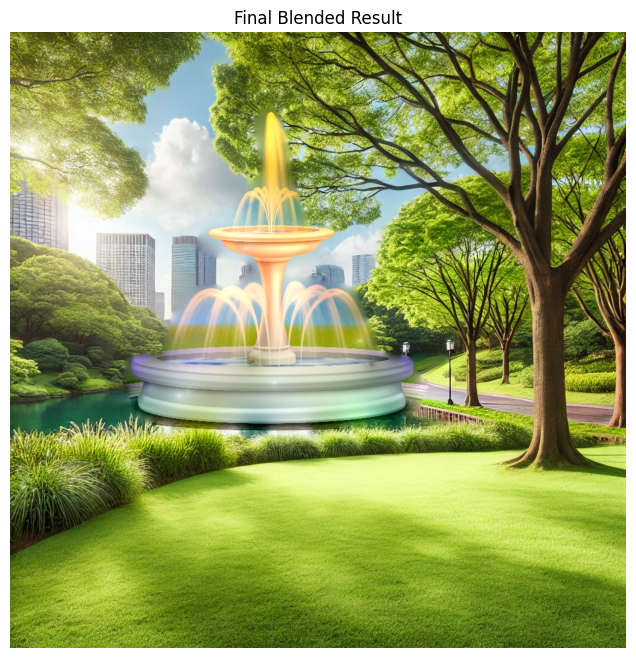

Interactive editing complete. Result saved as 'composite_result.jpg'
Source image was scaled to 80% of its original size relative to target
Interactive editing complete! Check the saved results.


In [5]:
if __name__ == "__main__":
    main()